In [49]:
from Classes.Analysis import Analysis
import numpy as np
from matplotlib import pyplot as plt
from Classes.Visualizer import Visualizer
from numpy import inf

class System(Analysis):
    def __init__(self, graph_location):
        super().__init__(graph_location)

    def odesystem(self, t, Y, *params):
        # start simple, bacteria-resource, see how the bacteria and reosurces grow/shrink, bacteria should hit carrying capacity, nutrient should reach 0, not negative, etc
        graph_object, phage_nodes, bacteria_nodes, nutrient_nodes, M, e_vector, tau_vector, v_matrix, K_matrix, r_matrix, B_matrix = params
        graph = graph_object.graph
        def g(N, v, K):
            return (N * v) / (N + K)

        Y = self.check_cutoff(Y)
        
        N, U, I, P = self.unflatten_initial_matrix(Y, [len(nutrient_nodes), len(bacteria_nodes), (len(bacteria_nodes), M), len(phage_nodes)])
        new_N = np.zeros_like(N)
        new_U = np.zeros_like(U)
        new_I = np.zeros_like(I)
        new_P = np.zeros_like(P)
        #update N vector
        for nutrient in nutrient_nodes:
            n_index = nutrient_nodes.index(nutrient)
            e_value = e_vector[n_index] 
            sum_g = 0
            sum_u = 0
            sum_i = 0
            for bacteria in bacteria_nodes:
                b_index = bacteria_nodes.index(bacteria)
                if graph.has_edge(bacteria, nutrient):
                    v = v_matrix[b_index, n_index]
                    K = K_matrix[b_index, n_index]
                    sum_g += g(N[n_index], v, K)
                    sum_u += U[b_index]
                    sum_i += np.sum(I[b_index])
            new_N[n_index] = -(e_value * sum_g) * (sum_u + sum_i)
        
        for uninfected in bacteria_nodes:
            u_index = bacteria_nodes.index(uninfected)
            g_sum = 0
            right = 0
            for nutrient in nutrient_nodes:
                n_index = nutrient_nodes.index(nutrient)
                if graph.has_edge(uninfected, nutrient):
                    g_sum += g(N[n_index], v_matrix[u_index, n_index], K_matrix[u_index, n_index])
            for phage in phage_nodes:
                p_index = phage_nodes.index(phage)
                if graph.has_edge(phage, uninfected):
                    right += r_matrix[p_index, u_index] * P[p_index]
            new_U[u_index] = g_sum * U[u_index] - right * U[u_index]

        for infected in bacteria_nodes:
            i_index = bacteria_nodes.index(infected)
            for infected_stage in range(0, M):
                if infected_stage == 0:
                    left_sum = 0
                    right_sum = 0
                    for phage in phage_nodes:
                        p_index = phage_nodes.index(phage)
                        if graph.has_edge(phage, infected):
                            left_sum += r_matrix[p_index, i_index] * P[p_index]
                            right_sum += M / tau_vector[i_index] * I[i_index, 0]
                    new_I[i_index, 0] = left_sum * U[i_index] - right_sum
                else:
                    m_tau = M / tau_vector[i_index]
                    right = I[i_index, infected_stage - 1] - I[i_index, infected_stage]
                    new_I[i_index, infected_stage] = m_tau * right
        
        for phage in phage_nodes:
            p_index = phage_nodes.index(phage)
            left_sum = 0
            right_sum = 0
            for infected in bacteria_nodes:
                i_index = bacteria_nodes.index(infected)
                if graph.has_edge(phage, infected):
                    left_sum += B_matrix[p_index, i_index] * M / tau_vector[i_index] * I[i_index, -1]
                    right_sum += r_matrix[p_index, i_index] * (U[i_index] + np.sum(I[i_index])) * P[p_index]
            new_P[p_index] = left_sum - right_sum

        flattened_y1 = self.flatten_lists_and_matrices(new_N, new_U, new_I, new_P)
        return flattened_y1

def optical_density(array, list_of_names):
    optical_list = []
    counter = 0
    # for i, group in enumerate(array):
    for j, item in enumerate(array):
        print(counter)
        if list_of_names[counter].lower() in ["uninfected", "infected", "bacteria", "b", "u", "i", "b0", "u0", "i0", "infect", "uninf", "inf", "uninfect"]:
            optical_list.append(item)
        counter += 1
    print(optical_list)
    return np.sum(optical_list, axis=0)


In [50]:
graph = System('example_2.gexf')
phage_nodes = graph.get_nodes_of_type('P')
bacteria_nodes = graph.get_nodes_of_type('B')
resource_nodes = graph.get_nodes_of_type('R')
environemnt_nodes = graph.get_nodes_of_type('E')

R0 = graph.initialize_new_parameter_from_node(resource_nodes, "Initial_Concentration")
U0 = graph.initialize_new_parameter_from_node(bacteria_nodes, "Initial_Population")
I0 = graph.initialize_new_matrix(len(U0), graph.M)
P0 = graph.initialize_new_parameter_from_node(phage_nodes, "Initial_Population")

e_vector = graph.initialize_new_parameter_from_node(resource_nodes, 'e')
tau_vector = graph.initialize_new_parameter_from_node(bacteria_nodes, 'tau')
v_matrix = graph.initialize_new_parameter_from_edges(bacteria_nodes, resource_nodes, 'v')
K_matrix = graph.initialize_new_parameter_from_edges(bacteria_nodes, resource_nodes, 'K')
r_matrix = graph.initialize_new_parameter_from_edges(phage_nodes, bacteria_nodes, 'r')
B_matrix = graph.initialize_new_parameter_from_edges(phage_nodes, bacteria_nodes, 'Burst_Size')
visualizer = Visualizer(graph)

{}
Solving ODE system
30
0
1
2
3
[array([9.70000000e+01, 9.69977543e+01, 9.69753162e+01, 9.67527624e+01,
       9.52897051e+01, 9.37123385e+01, 9.19692862e+01, 8.99055778e+01,
       8.74850467e+01, 8.46131144e+01, 8.06264624e+01, 7.31576212e+01,
       5.83354466e+01, 3.84868334e+01, 2.02580960e+01, 8.44730551e+00,
       2.80088130e+00, 8.66974305e-01, 2.71392584e-01, 8.70423688e-02,
       2.71804480e-02, 9.49538663e-03, 2.99779423e-03, 9.52058459e-04,
       3.07577103e-04, 1.16657048e-04, 4.14871728e-05, 1.64691286e-05,
       5.76360792e-06, 1.60106166e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning:

The following arguments have no effect for a chosen solver: `min_step`.



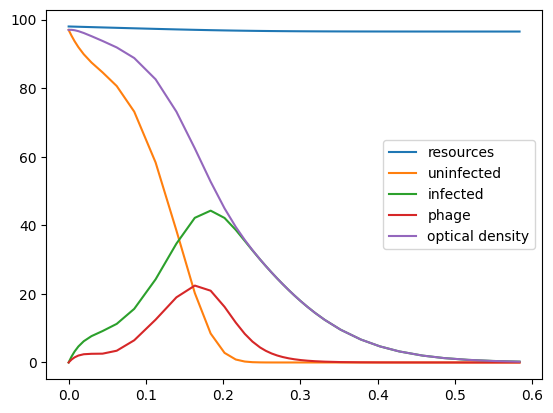

In [55]:
new_graphing_data = [R0, U0, I0, P0]
flattened = graph.flatten_lists_and_matrices(*new_graphing_data)
new_non_graphing_data_vectors = [e_vector, tau_vector]
new_non_graphing_data_matrices = [v_matrix, K_matrix, r_matrix, B_matrix]

solved_system = graph.solve_system(graph.odesystem, flattened, graph, *[phage_nodes, bacteria_nodes, resource_nodes, int(graph.M)], *new_non_graphing_data_vectors, *new_non_graphing_data_matrices)
solved_y = solved_system.y
overall_y = graph.unflatten_initial_matrix(solved_y, [len(resource_nodes), len(bacteria_nodes), int(graph.M), len(phage_nodes)])
overall_y[2] = visualizer.sum_up_columns(overall_y[2], int(graph.M))
new_overall_y = [overall_y[i][0] for i in range(len(overall_y))]
row_of_names = ["resources", "uninfected", "infected", "phage"]
optical_density_list = optical_density(new_overall_y, row_of_names)
for i in range(len(new_overall_y)):
    plt.plot(solved_system.t[:40], new_overall_y[i][:40], label=row_of_names[i])
plt.plot(solved_system.t[:40], optical_density_list[:40], label="optical density")
plt.legend()